Import a bunch of packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

Import the rent data set.

In [ ]:
rent = pd.read_csv("https://richardson.byu.edu/220/rent.csv")
rent

,BHK,Rent,Size,AreaType,City,FurnishingStatus,Preferred,Bathroom,Contact
0,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner
...,...,...,...,...,...,...,...,...,...
4738,2,15000,1000,Carpet Area,Hyderabad,Semi-Furnished,Bachelors/Family,2,Contact Owner
4739,3,29000,2000,Super Area,Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner
4740,3,35000,1750,Carpet Area,Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Agent
4741,3,45000,1500,Carpet Area,Hyderabad,Semi-Furnished,Family,2,Contact Agent


Explore using a log transformation.

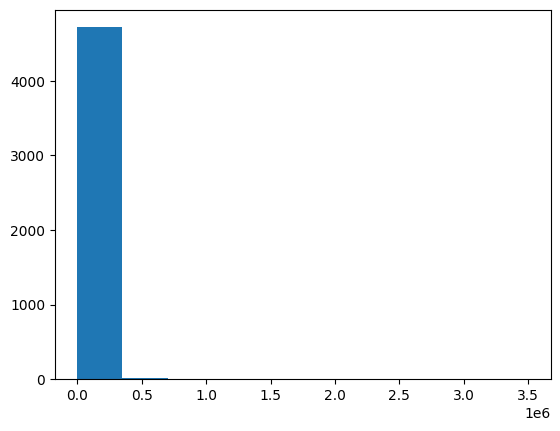

(array([6.000e+00, 2.070e+02, 1.670e+03, 1.496e+03, 7.970e+02, 3.680e+02,
        1.610e+02, 3.400e+01, 3.000e+00, 1.000e+00]),
 array([ 7.09007684,  7.8878965 ,  8.68571617,  9.48353584, 10.28135551,
        11.07917518, 11.87699485, 12.67481452, 13.47263419, 14.27045386,
        15.06827353]),
 <BarContainer object of 10 artists>)

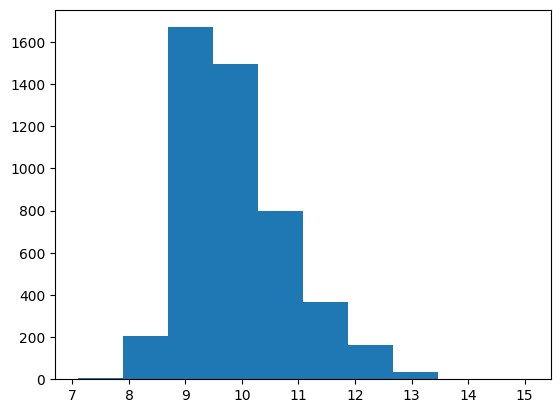

In [ ]:
plt.hist(rent.Rent)
plt.show()

plt.hist(np.log(rent.Rent))

In [ ]:
rent_predictors = rent.drop(columns = ["Rent"])

# Dummify
X = pd.get_dummies(rent_predictors,drop_first = True)

y = np.log(rent["Rent"])

# split into train/test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Scale the data
scale_X = StandardScaler()
scale_X.fit(X_train)
X_train_scaled = scale_X.transform(X_train)

scale_y = StandardScaler()
scale_y.fit(y_train.values.reshape(-1,1))
y_train_scaled = scale_y.transform(y_train.values.reshape(-1,1))

# Fit a linear regression model
reg_prep = LinearRegression()
mod_reg = reg_prep.fit(X_train_scaled,y_train_scaled)
mod_reg.coef_

array([[ 0.19839924,  0.27748211,  0.15780071, -0.0232345 , -0.0194272 ,
         0.05867906, -0.06489305, -0.10328772,  0.41943598, -0.08760906,
        -0.14128136, -0.02076681, -0.03807989, -0.1835807 ]])

Find the R^2 for the regression model.

In [ ]:
X_test_scaled = scale_X.transform(X_test)
preds = scale_y.inverse_transform(mod_reg.predict(X_test_scaled))
print("Out of Sample R^2: ",r2_score(y_test,preds))

in_preds = scale_y.inverse_transform(mod_reg.predict(X_train_scaled))
print("In Sample R^2: ",r2_score(y_train,in_preds))


Out of Sample R^2:  0.8183927056673966
In Sample R^2:  0.8107692645316728


Make a Lasso regession model and calculate the R^2. It is about the same as the linear model.

In [ ]:
# Import new package
from sklearn.linear_model import Lasso

# Need to specify alpha. Alpha is a shrinkage parameter. The larger alpha
# is the more shrinkage there is. Shrinkage means (roughly) less overfitting
reg_lasso = Lasso(alpha=.05)

# Find R^2 for the Lasso model
reg_lasso.fit(X_train_scaled, y_train_scaled)
# Output is framed differently than the regression model (note the extra [])
preds_lasso = scale_y.inverse_transform([reg_lasso.predict(X_test_scaled)])
print("Out of Sample R^2: ",r2_score(y_test,preds_lasso[0]))

in_preds = scale_y.inverse_transform([reg_lasso.predict(X_train_scaled)])
print("In Sample R^2: ",r2_score(y_train,in_preds[0]))

Out of Sample R^2:  0.7952758177778366
In Sample R^2:  0.7923072048120053


Change alpha in the Lasso model and see how it affects the coefficients.

In [ ]:
reg_lasso.coef_

array([ 0.16658005,  0.21915579,  0.18760607, -0.        , -0.        ,
        0.02035866, -0.01132814, -0.05159878,  0.38425236, -0.        ,
       -0.04318082, -0.        , -0.        , -0.20608071])

We did not see much difference there. Let's add higher order terms to the model. Recall this code that splits the numeric and categorical variables, creates dummies for the categorical and adds all higher order terms for the numeric.

In [ ]:
# Split predictors into continuous and categorical
numeric_cols = ['BHK','Size','Bathroom']
categorical_cols = ['AreaType','City','FurnishingStatus','Preferred','Contact']

# Separate the DataFrame into numeric and categorical DataFrames
X_numeric = rent[numeric_cols]
X_categorical = rent[categorical_cols]

# Apply Polynomial Transformation to continuous variables
# Note that this adds the needed columns for adding an intercept to the model
poly = PolynomialFeatures(2)
X_numeric_transformed = poly.fit_transform(X_numeric)
hot_names = poly.get_feature_names_out(X_numeric.columns)
X_num_poly = pd.DataFrame(X_numeric_transformed,columns = hot_names)

# Convert categorical variables to dummies
X_categorical_dummies = pd.get_dummies(X_categorical, drop_first=True)

X_full = pd.concat([X_num_poly,X_categorical_dummies],axis = 1)

X_full

,1,BHK,Size,Bathroom,BHK^2,BHK Size,BHK Bathroom,Size^2,Size Bathroom,Bathroom^2,...,City_Chennai,City_Delhi,City_Hyderabad,City_Kolkata,City_Mumbai,FurnishingStatus_Semi-Furnished,FurnishingStatus_Unfurnished,Preferred_Bachelors/Family,Preferred_Family,Contact_Contact Owner
0,1.0,2.0,1100.0,2.0,4.0,2200.0,4.0,1210000.0,2200.0,4.0,...,0,0,0,1,0,0,1,1,0,1
1,1.0,2.0,800.0,1.0,4.0,1600.0,2.0,640000.0,800.0,1.0,...,0,0,0,1,0,1,0,1,0,1
2,1.0,2.0,1000.0,1.0,4.0,2000.0,2.0,1000000.0,1000.0,1.0,...,0,0,0,1,0,1,0,1,0,1
3,1.0,2.0,800.0,1.0,4.0,1600.0,2.0,640000.0,800.0,1.0,...,0,0,0,1,0,0,1,1,0,1
4,1.0,2.0,850.0,1.0,4.0,1700.0,2.0,722500.0,850.0,1.0,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4738,1.0,2.0,1000.0,2.0,4.0,2000.0,4.0,1000000.0,2000.0,4.0,...,0,0,1,0,0,1,0,1,0,1
4739,1.0,3.0,2000.0,3.0,9.0,6000.0,9.0,4000000.0,6000.0,9.0,...,0,0,1,0,0,1,0,1,0,1
4740,1.0,3.0,1750.0,3.0,9.0,5250.0,9.0,3062500.0,5250.0,9.0,...,0,0,1,0,0,1,0,1,0,0
4741,1.0,3.0,1500.0,2.0,9.0,4500.0,6.0,2250000.0,3000.0,4.0,...,0,0,1,0,0,1,0,0,1,0


This code adds interactions between all numeric and all categorical variables, which was not included in the last code. This also adds interactions between categorical variables and other categorical variables. Note that we get an error because we are consistently growing the size of a large matrix, which is potentially a memory issue. Perhaps you or I could find a better way to do it, but for now this is how we will roll.

In [ ]:
# Add interactions between all categorical and all numeric variables
for numeric_col in numeric_cols:
    for dummy_col in X_categorical_dummies:
        interaction_term_name = f"{numeric_col}_x_{dummy_col}"
        X_full[interaction_term_name] = X_full[numeric_col] * X_full[dummy_col]

# Adds interactions between categorical variables and all other categorical variables
for dummy_col1 in X_categorical_dummies:
    for dummy_col2 in X_categorical_dummies:
        interaction_term_name = f"{dummy_col1}_x_{dummy_col2}"
        X_full[interaction_term_name] = X_full[dummy_col1] * X_full[dummy_col2]


print(X_full)

        1  BHK    Size  Bathroom  BHK^2  BHK Size  BHK Bathroom     Size^2  \
0     1.0  2.0  1100.0       2.0    4.0    2200.0           4.0  1210000.0   
1     1.0  2.0   800.0       1.0    4.0    1600.0           2.0   640000.0   
2     1.0  2.0  1000.0       1.0    4.0    2000.0           2.0  1000000.0   
3     1.0  2.0   800.0       1.0    4.0    1600.0           2.0   640000.0   
4     1.0  2.0   850.0       1.0    4.0    1700.0           2.0   722500.0   
...   ...  ...     ...       ...    ...       ...           ...        ...   
4738  1.0  2.0  1000.0       2.0    4.0    2000.0           4.0  1000000.0   
4739  1.0  3.0  2000.0       3.0    9.0    6000.0           9.0  4000000.0   
4740  1.0  3.0  1750.0       3.0    9.0    5250.0           9.0  3062500.0   
4741  1.0  3.0  1500.0       2.0    9.0    4500.0           6.0  2250000.0   
4742  1.0  2.0  1000.0       2.0    4.0    2000.0           4.0  1000000.0   

      Size Bathroom  Bathroom^2  ...  Contact_Contact Owner_x_C

<ipython-input-33-75a2af5ffda6>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_full[interaction_term_name] = X_full[dummy_col1] * X_full[dummy_col2]
<ipython-input-33-75a2af5ffda6>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_full[interaction_term_name] = X_full[dummy_col1] * X_full[dummy_col2]
<ipython-input-33-75a2af5ffda6>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

The R$^2$ actually does not get much better.

In [ ]:

# split into train/test groups
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=1234)

scale_X = StandardScaler()
scale_X.fit(X_train)
X_train_scaled = scale_X.transform(X_train)

reg_prep = LinearRegression()
mod_reg = reg_prep.fit(X_train_scaled,y_train_scaled)

X_test_scaled = scale_X.transform(X_test)
preds = scale_y.inverse_transform(mod_reg.predict(X_test_scaled))
print("Out of Sample R^2: ",r2_score(y_test,preds))

in_preds = scale_y.inverse_transform(mod_reg.predict(X_train_scaled))
print("In Sample R^2: ",r2_score(y_train,in_preds))

Out of Sample R^2:  0.8164160508897004
In Sample R^2:  0.8315296818059655


The Lasso model can be used to reduce overfitting in a regression model.

In [ ]:
reg_lasso = Lasso(alpha=.002)
reg_lasso.fit(X_train_scaled, y_train_scaled)
preds_lasso = scale_y.inverse_transform([reg_lasso.predict(X_test_scaled)])
print("Out of Sample R^2: ",r2_score(y_test,preds_lasso[0]))

in_preds = scale_y.inverse_transform([reg_lasso.predict(X_train_scaled)])
print("In Sample R^2: ",r2_score(y_train,in_preds[0]))


Out of Sample R^2:  0.8267271866185465
In Sample R^2:  0.8269906738430122


Change alpha and see that these numbers will change.

In [ ]:
alpha_vec = np.linspace(0.0001,.01,10)
mse_vals = [0]*10
for i in range(10):
  reg_lasso = Lasso(alpha=alpha_vec[i])
  reg_lasso.fit(X_train_scaled, y_train_scaled)
  preds_lasso = scale_y.inverse_transform([reg_lasso.predict(X_test_scaled)])
  mse_vals[i] = mean_squared_error(y_test,preds_lasso[0])

mse_vals

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.141e+01, tolerance: 3.794e-01
  model = cd_fast.enet_coordinate_descent(


[0.1648146053860066,
 0.1587068796904416,
 0.15819873674482118,
 0.15855243099680263,
 0.1592759336026402,
 0.1601097518621277,
 0.16129289705635066,
 0.16244715394544249,
 0.16296018503517243,
 0.16352573977573084]

Use LassoCV

In [ ]:
from sklearn.linear_model import LassoCV

# Search for the best alpha
# Set cv = 5. This makes 5 different train-test splits in the data
# And fits on all 5 train sets and predicts on the respective test sets
model_best = LassoCV(cv=5)
model_best.fit(X_train_scaled, y_train_scaled)

# Get the best alpha the model found.
model_best.alpha_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.002259581744706899

Use the best alpha

In [ ]:
alpha_best = model_best.alpha_
reg_lasso = Lasso(alpha=alpha_best)
reg_lasso.fit(X_train_scaled, y_train_scaled)
preds_lasso = scale_y.inverse_transform([reg_lasso.predict(X_test_scaled)])
r2_score(y_test,preds_lasso[0])

0.8267181105631182